# Data Preparation, Transition Matrix, Baseline Model

### Import Libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random
import scipy
from scipy.stats import chisquare

from collections import Counter

### Load Data

In [ ]:
data_raw = pd.read_csv('data/data-2010-2024.csv', delimiter=",", skiprows=3)
data_test = pd.read_csv('data/om-2025-test.csv', delimiter=",", skiprows=3 )

In [4]:
data_test['time'] = pd.to_datetime(data_test['time'], format='%Y-%m-%dT%H:%M', errors='coerce')

### Functions 

In [ ]:
# mapping for renaming purposes
weather_columns = {
    'temperature_2m (°C)': 'temp',
    'weather_code (wmo code)': 'weather_code',
    'precipitation (mm)': 'precip',
    'cloud_cover (%)': 'cloud_cover',
    'wind_speed_10m (km/h)': 'wind_speed',
    'sunshine_duration (s)': 'sunshine',    
}

In [ ]:
def add_time_columns(df):
    '''
    Function to convert time column to datetime and add more time related columns, such as month, day, year ... 

    Parameters:
        df (pd.DataFrame): The input DataFrame containing weather data.

    '''
    constant_year = 2000
    df['time'] = pd.to_datetime(df['time'], errors='coerce')  # Handle parsing errors
    df = df.dropna(subset=['time'])  # Drop rows with invalid dates
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['year'] = df['time'].dt.year
    df['minute'] = df['time'].dt.minute
    df['second'] = df['time'].dt.second
    df['hour'] = df['time'].dt.hour
    df['month_day_time'] = pd.to_datetime(
        df['month'].astype(str) + '-' +
        df['day'].astype(str) + '-' +
        str(constant_year) + ' ' +
        df['hour'].astype(str).str.zfill(2) + ':' +
        df['minute'].astype(str).str.zfill(2) + ':' +
        df['second'].astype(str).str.zfill(2),
        format='%m-%d-%Y %H:%M:%S'
    )
    return df


def rename_columns(df):
    '''
    Function to rename columns in accordance to mapping
    
    Parameters:
        df (pd.DataFrame): The input DataFrame containing weather data.
    '''
    df.rename(columns=weather_columns, inplace=True)
    return df



In [7]:
all_data = add_time_columns(data_raw)
all_data = rename_columns(all_data)
test_data = add_time_columns(data_test)
test_data = rename_columns(test_data)

/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_18998/3863460532.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['time'].dt.month
/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_18998/3863460532.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df['time'].dt.day
/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_18998/3863460532.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [8]:
all_data.columns

Index(['time', 'temp', 'precip', 'weather_code', 'cloud_cover', 'wind_speed',
       'sunshine', 'month', 'day', 'year', 'minute', 'second', 'hour',
       'month_day_time'],
      dtype='object')

In [9]:
test_data.columns

Index(['time', 'sunshine', 'temp', 'precip', 'cloud_cover', 'wind_speed',
       'month', 'day', 'year', 'minute', 'second', 'hour', 'month_day_time'],
      dtype='object')

In [10]:
# checking for null values
all_data.isnull().values.any()
test_data.isnull().values.any()

np.False_

### Data Overview - weather variables distribution

In [ ]:
def plot_weather_distribution(weather_var, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(all_data['time'], all_data[weather_var])
    plt.xlabel('Time', size=14)
    plt.ylabel(ylabel, size=14)
    plt.title(title, size=20)
    # add lines for each year
    for year in range(2010, 2026):
        plt.axvline(pd.to_datetime(f'{year}-01-01'), color='r', linestyle='--', alpha=0.5)

    plt.show()


### Average of Weather Variables Data Overview

In [ ]:
weather_var = ['temp', 'precip', 'cloud_cover', 'wind_speed', 'sunshine']
def plot_average_weather_variable(weather_var, title, ylabel):
    """
    Plots the average weather variable over time.

    """
    average_daily = all_data.groupby(['year', 'month', 'day'])[weather_var].mean().reset_index()
    average_daily['date'] = pd.to_datetime(
        average_daily[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))
    average_daily = average_daily.sort_values(by='date')
    plt.figure(figsize=(12, 6))
    plt.plot(average_daily['date'], average_daily[weather_var])
    plt.xlabel('Date', size=14)
    plt.ylabel(ylabel, size=14)
    plt.title(title, size =20)
    plt.xticks(rotation=45)
    # add lines for each year
    for year in range(2010, 2026):
        plt.axvline(pd.to_datetime(f'{year}-01-01'), color='r', linestyle='--', alpha=0.5)


    plt.grid()
    plt.show()
# plot_average_weather_variable('temp', title = 'Average Daily Temperature from 2010 to 2024', ylabel = 'Average Daily Temperature (°C)')
# plot_average_weather_variable('precip', title = 'Average Daily Precipitation from 2010 to 2024', ylabel = 'Average Daily Precipitation (mm)')
# plot_average_weather_variable('cloud_cover', title = 'Average Daily Cloud Cover from 2010 to 2024', ylabel = 'Average Daily Cloud Cover (%)')
# plot_average_weather_variable('wind_speed', title = 'Average Daily Wind Speed from 2010 to 2024', ylabel = 'Average Daily Wind Speed (km/h)')   
# plot_average_weather_variable('sunshine', title = 'Average Daily Sunshine Duration from 2010 to 2024', ylabel = 'Average Daily Sunshine Duration (s)')


### Categorize Weather Variables

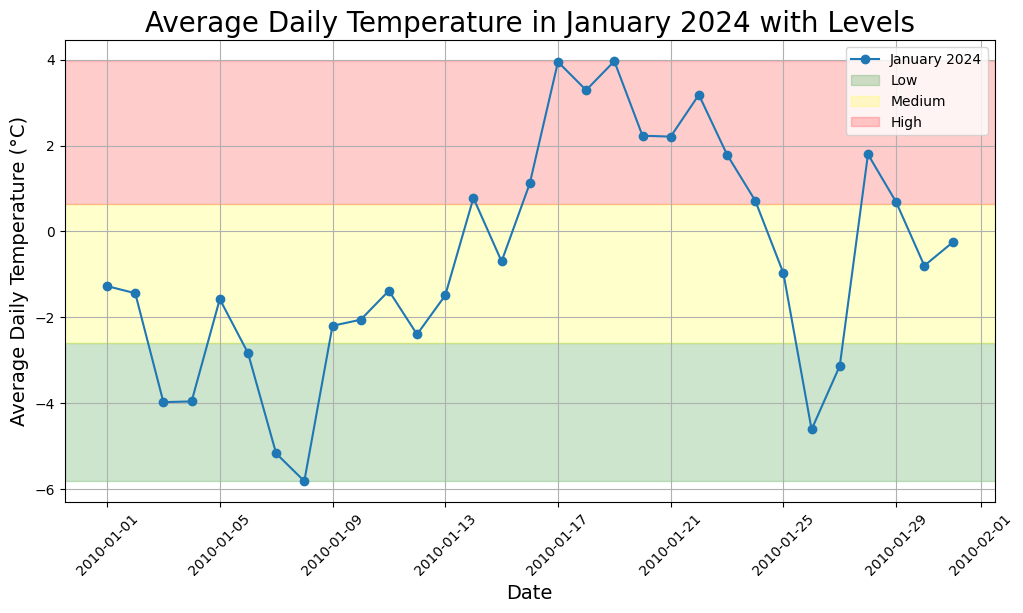

In [13]:
def average_daily(df, weather_var):
    """
    Calculates the average daily weather variable.
    """
    average_daily = df.groupby(['year', 'month', 'day'])[weather_var].mean().reset_index()
    average_daily['date'] = pd.to_datetime(
        average_daily[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))
    return average_daily
# Filter data for January 2024

average_daily_temp = average_daily(all_data, 'temp')
january_2024 = average_daily_temp[
    (average_daily_temp['year'] == 2010) & (average_daily_temp['month'] == 1)
]

# Define thresholds for low, medium, and high levels
low_threshold = january_2024['temp'].min() + (january_2024['temp'].max() - january_2024['temp'].min()) * 0.33
high_threshold = january_2024['temp'].min() + (january_2024['temp'].max() - january_2024['temp'].min()) * 0.66

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(january_2024['date'], january_2024['temp'], marker='o', label='January 2024')

# Add horizontal bands for low, medium, and high levels
plt.axhspan(january_2024['temp'].min(), low_threshold, color='green', alpha=0.2, label='Low')
plt.axhspan(low_threshold, high_threshold, color='yellow', alpha=0.2, label='Medium')
plt.axhspan(high_threshold, january_2024['temp'].max(), color='red', alpha=0.2, label='High')

# Add labels and title
plt.xlabel('Date', size=14)
plt.ylabel('Average Daily Temperature (°C)', size=14)
plt.title('Average Daily Temperature in January 2024 with Levels', size=20)
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

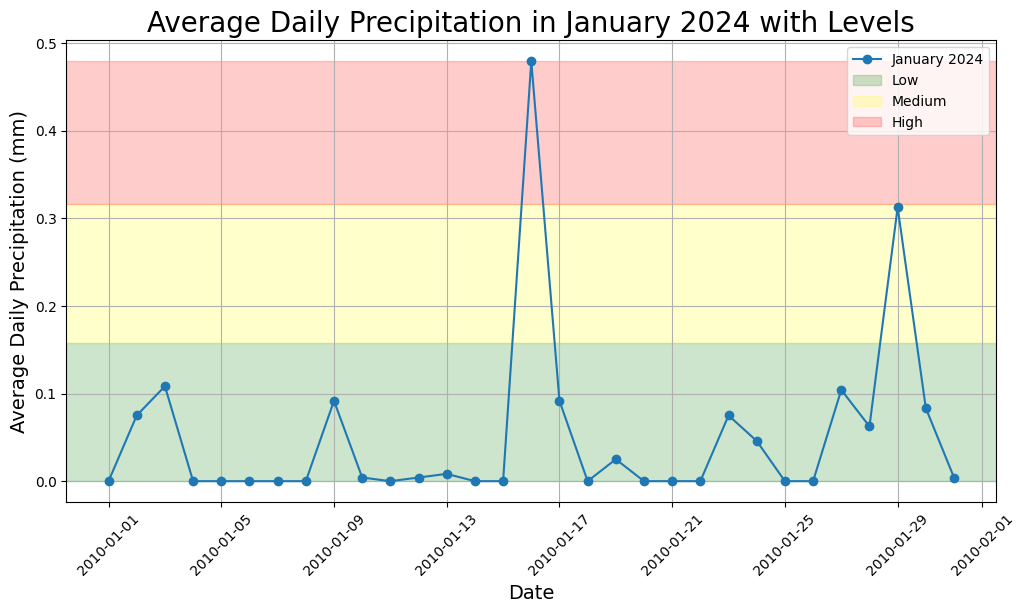

In [14]:

average_daily_temp = average_daily(all_data, 'precip')
january_2024 = average_daily_temp[
    (average_daily_temp['year'] == 2010) & (average_daily_temp['month'] == 1)
]

# Define thresholds for low, medium, and high levels
low_threshold = january_2024['precip'].min() + (january_2024['precip'].max() - january_2024['precip'].min()) * 0.33
high_threshold = january_2024['precip'].min() + (january_2024['precip'].max() - january_2024['precip'].min()) * 0.66

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(january_2024['date'], january_2024['precip'], marker='o', label='January 2024')

# Add horizontal bands for low, medium, and high levels
plt.axhspan(january_2024['precip'].min(), low_threshold, color='green', alpha=0.2, label='Low')
plt.axhspan(low_threshold, high_threshold, color='yellow', alpha=0.2, label='Medium')
plt.axhspan(high_threshold, january_2024['precip'].max(), color='red', alpha=0.2, label='High')

# Add labels and title
plt.xlabel('Date', size=14)
plt.ylabel('Average Daily Precipitation (mm)', size=14)
plt.title('Average Daily Precipitation in January 2024 with Levels', size=20)
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

## Defining Weather States

In [15]:
test_data['temp'] = pd.to_numeric(test_data['temp'], errors='coerce')
test_data['sunshine'] = pd.to_numeric(test_data['sunshine'], errors='coerce')
test_data.dtypes

/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_18998/2214730314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['temp'] = pd.to_numeric(test_data['temp'], errors='coerce')
/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_18998/2214730314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['sunshine'] = pd.to_numeric(test_data['sunshine'], errors='coerce')


time              datetime64[ns]
sunshine                 float64
temp                     float64
precip                   float64
cloud_cover              float64
wind_speed               float64
month                      int32
day                        int32
year                       int32
minute                     int32
second                     int32
hour                       int32
month_day_time    datetime64[ns]
dtype: object

#### Average the Data

In [16]:
daily_mean_test_df = test_data.select_dtypes(include=[np.number]).groupby(['year', 'month', 'day']).mean().reset_index()

In [ ]:
daily_mean_df = all_data.groupby(['year', 'month', 'day']).mean().reset_index()

#### Calculate Monthly Percentiles

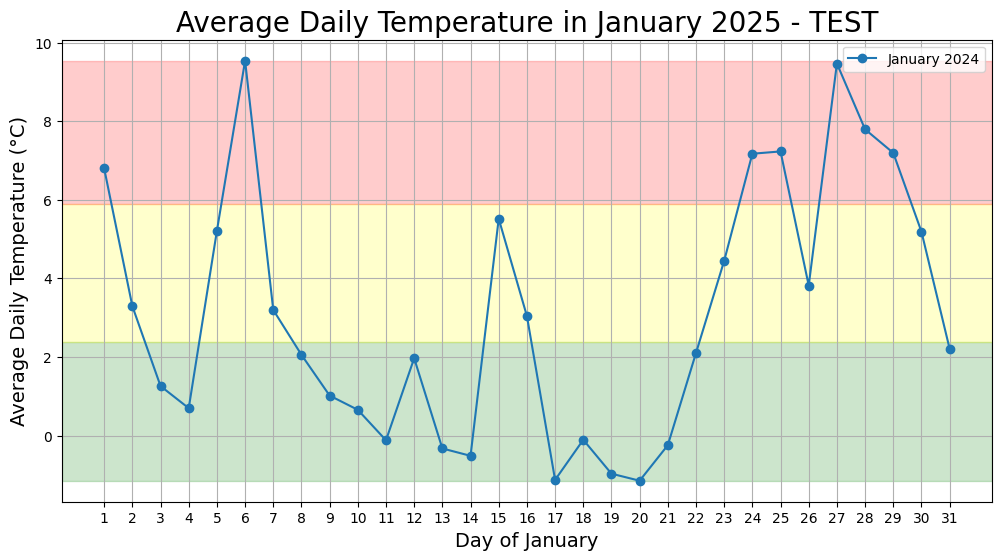

In [19]:

weather_var = 'temp'
plt.figure(figsize=(12, 6))
# Plot lines for each year 

plt.plot(daily_mean_test_df['day'], daily_mean_test_df[weather_var], marker='o', label=f'January {year}')
plt.xlabel('Day of January', size=14)
plt.ylabel('Average Daily Temperature (°C)', size=14)
plt.title('Average Daily Temperature in January 2025 - TEST', size=20)
plt.xticks(daily_mean_test_df['day'])
plt.grid()
plt.legend()


# Define thresholds for low, medium, and high levels
low_threshold = daily_mean_test_df[weather_var].min() + (daily_mean_test_df[weather_var].max() - daily_mean_test_df[weather_var].min()) * 0.33
high_threshold = daily_mean_test_df[weather_var].min() + (daily_mean_test_df[weather_var].max() - daily_mean_test_df[weather_var].min()) * 0.66

# Add horizontal bands for low, medium, and high levels
plt.axhspan(daily_mean_test_df[weather_var].min(), low_threshold, color='green', alpha=0.2, label='Low')
plt.axhspan(low_threshold, high_threshold, color='yellow', alpha=0.2, label='Medium')
plt.axhspan(high_threshold, daily_mean_test_df[weather_var].max(), color='red', alpha=0.2, label='High')


In [20]:
def calculate_percentiles_and_categorize(df, month):
    """
    Calculates percentiles for a specific month and categorizes weather variables into low, medium, and high.
    Includes zero precipitation values in the "Low" category.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing weather data.
        month (int): The month for which to calculate percentiles (1 = January, ..., 12 = December).

    Returns:
        pd.DataFrame: A new DataFrame with additional columns for categorized weather variables.
    """
    # Filter data for the specified month
    month_data = df[df['month'] == month].copy()

    # Calculate percentiles for each weather variable
    thresholds = {}
    for variable in ['temp', 'precip', 'cloud_cover', 'wind_speed', 'sunshine']:
        variable_data = month_data[variable].dropna()

        if variable == 'precip':
            # Include zero values in the "Low" category
            low = np.percentile(variable_data, 33)
            high = np.percentile(variable_data, 66)
            thresholds[variable] = {'low': low, 'high': high}
        else:
            # Standard percentile calculation
            low = np.percentile(variable_data, 33)
            high = np.percentile(variable_data, 66)
            thresholds[variable] = {'low': low, 'high': high}

    # Categorize each variable based on the calculated thresholds
    for variable in thresholds.keys():
        low, high = thresholds[variable]['low'], thresholds[variable]['high']
        month_data[f'{variable}_category'] = month_data[variable].apply(
            lambda x: 'Low' if x <= low else 'Medium' if x < high else 'High'
        )

    return month_data

In [21]:
print(daily_mean_test_df.columns)

Index(['year', 'month', 'day', 'sunshine', 'temp', 'precip', 'cloud_cover',
       'wind_speed', 'minute', 'second', 'hour'],
      dtype='object')


#### Combine Weather Categories into Weather States
Thus each state has n amount of weather categories. \
**There will be different experimental setups:**
1) 2 variables - Temperature and Precipitation
2) 5 variables - Temperature, Precipitation, Wind Speed, Cloud Cover, Sunshine Duration

In [22]:
df_states1 = calculate_percentiles_and_categorize(month_data, 1)


In [23]:
df_states1_test = calculate_percentiles_and_categorize(daily_mean_test_df, 1)

In [24]:
df_states1 = df_states1[['year', 'month', 'day', 'temp_category', 'precip_category', 'cloud_cover_category', 'wind_speed_category', 'sunshine_category']]
df_states1_test = df_states1_test[['year', 'month', 'day', 'temp_category', 'precip_category', 'cloud_cover_category', 'wind_speed_category', 'sunshine_category']]

In [25]:
# 1st Experiment - 2 variables - Temperature and Precipitation
# combine categories into 2 variable state
df_states1['state1'] = df_states1[['temp_category', 'precip_category']].agg('-'.join, axis=1)
df_states1_test['state1_test'] = df_states1_test[['temp_category', 'precip_category']].agg('-'.join, axis=1)

In [26]:
print(df_states1['precip_category'].unique())
print(df_states1['temp_category'].unique())

['Low' 'Medium' 'High']
['Low' 'Medium' 'High']


In [27]:
# make df_states1 a csv file
df_states1.to_csv('data/df_states1.csv', index=False)

In [28]:
df_states1['state1'].unique()

array(['Low-Low', 'Low-Medium', 'Low-High', 'Medium-High', 'Medium-Low',
       'Medium-Medium', 'High-High', 'High-Medium', 'High-Low'],
      dtype=object)

In [29]:
df_states1_test['state1_test'].unique()

array(['High-High', 'Medium-High', 'Medium-Medium', 'Low-Medium',
       'Low-High', 'Medium-Low', 'Low-Low', 'High-Medium'], dtype=object)

#### Creating Transition Matrix 

In [30]:
df = df_states1[['state1']].copy()
df_test = df_states1_test[['state1_test']].copy()

In [31]:
# Define the next state
df['next_state'] = df['state1'].shift(-1)
# Drop the last row since it has no next state
df = df.dropna(subset=['next_state'])
# Create a transition matrix with raw counts
transition_counts = pd.crosstab(df['state1'], df['next_state'])

print(df)

           state1   next_state
0         Low-Low   Low-Medium
1      Low-Medium     Low-High
2        Low-High      Low-Low
3         Low-Low      Low-Low
4         Low-Low      Low-Low
...           ...          ...
5138    High-High   Medium-Low
5139   Medium-Low   Medium-Low
5140   Medium-Low     High-Low
5141     High-Low  High-Medium
5142  High-Medium     High-Low

[464 rows x 2 columns]


In [32]:
# count amounts of states in the state1 column
state_counts = df['state1'].value_counts()
next_state_counts = df['next_state'].value_counts()

In [33]:
print(transition_counts)

next_state     High-High  High-Low  High-Medium  Low-High  Low-Low  \
state1                                                               
High-High             40         6           18         0        0   
High-Low               8         6            7         0        0   
High-Medium           16         4            8         0        0   
Low-High               0         1            0         5        7   
Low-Low                3         1            1        10       52   
Low-Medium             1         2            1         5       17   
Medium-High            7         0            2         5        3   
Medium-Low             8         2            3         0        7   
Medium-Medium          8         3            2         3        3   

next_state     Low-Medium  Medium-High  Medium-Low  Medium-Medium  
state1                                                             
High-High               2            8           4             13  
High-Low                0

In [34]:
# Normalize the transition counts to calculate probabilities
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)
# Fill NaN values with 0 (in case some rows have no transitions)
transition_matrix = transition_matrix.fillna(0)
# Print the transition matrix
print(transition_matrix)

next_state     High-High  High-Low  High-Medium  Low-High   Low-Low  \
state1                                                                
High-High       0.439560  0.065934     0.197802  0.000000  0.000000   
High-Low        0.333333  0.250000     0.291667  0.000000  0.000000   
High-Medium     0.380952  0.095238     0.190476  0.000000  0.000000   
Low-High        0.000000  0.035714     0.000000  0.178571  0.250000   
Low-Low         0.033333  0.011111     0.011111  0.111111  0.577778   
Low-Medium      0.027778  0.055556     0.027778  0.138889  0.472222   
Medium-High     0.142857  0.000000     0.040816  0.102041  0.061224   
Medium-Low      0.181818  0.045455     0.068182  0.000000  0.159091   
Medium-Medium   0.133333  0.050000     0.033333  0.050000  0.050000   

next_state     Low-Medium  Medium-High  Medium-Low  Medium-Medium  
state1                                                             
High-High        0.021978     0.087912    0.043956       0.142857  
High-Low      

In [35]:
# Verify that rows sum to 1
row_sums = transition_matrix.sum(axis=1)
print("Row sums (should all be 1):")
print(row_sums)

Row sums (should all be 1):
state1
High-High        1.0
High-Low         1.0
High-Medium      1.0
Low-High         1.0
Low-Low          1.0
Low-Medium       1.0
Medium-High      1.0
Medium-Low       1.0
Medium-Medium    1.0
dtype: float64


## Markov Chain Implementation 

In [ ]:
def simulate_markov_chain(transition_matrix, states, initial_state, steps):
    '''
    Simulates a Markov Chain
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states
        initial_state: Starting state for the simulation
        steps: Number of steps to simulate
        
    Returns:
        List of states in the simulated sequence
    '''

    # initialise current state
    current_state = initial_state
    
    # add current state to the list of sequences 
    state_sequence = [current_state]
    
    # generate n steps of states
    for _ in range(steps):
        # get probability for the current state
        probabilities = transition_matrix.loc[current_state].values
        # choose the next state based on the probabilities 
        next_state = np.random.choice(states, p=probabilities)
        state_sequence.append(next_state)
        current_state = next_state
    
    return state_sequence



In [ ]:

def monte_carlo_markov_chain(transition_matrix, states, initial_state=None, steps=31, n_simulations=1000):
    '''
    Performs Monte Carlo simulation of a Markov Chain
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states
        initial_state: Starting state (if None, will be randomly chosen based on stationary distribution)
        steps: Number of steps to simulate in each run
        n_simulations: Number of simulations to run
        
    Returns:
        Dictionary containing:
        - 'mean_counts': Average count of each state across all simulations
        - 'std_counts': Standard deviation of counts for each state
        - 'ci_lower', 'ci_upper': 95% confidence intervals for state frequencies
        - 'all_sequences': List of all simulated sequences (optional, can be removed if memory is a concern)
    '''


    # Initialize storage for all simulations
    all_sequences = []
    all_counts = {state: [] for state in states}

    # If no initial state is provided, use stationary distribution to choose one
    if initial_state is None:
        # Approximate stationary distribution by raising transition matrix to high power
        # This requires transition_matrix to be a numpy array, so convert if needed
        if isinstance(transition_matrix, pd.DataFrame):
            tm_numpy = transition_matrix.values
        else:
            tm_numpy = transition_matrix
            
        # Initialize a uniform distribution
        p = np.ones(len(states)) / len(states)
        
        # Multiply by transition matrix multiple times to approximate stationary distribution
        for _ in range(100):  # Usually 100 iterations is enough for convergence
            p = p @ tm_numpy
            
        # Choose initial state based on stationary distribution
        initial_state = np.random.choice(states, p=p)
    
    # Run n_simulations
    for _ in range(n_simulations):
        # For each simulation, potentially use a different initial state from stationary distribution
        if initial_state is None:
            sim_initial_state = np.random.choice(states, p=p)
        else:
            sim_initial_state = initial_state
            
        # Run one simulation
        sequence = simulate_markov_chain(transition_matrix, states, sim_initial_state, steps)
        all_sequences.append(sequence)
        
        # Count occurrences of each state in this simulation
        counts = Counter(sequence)
        for state in states:
            all_counts[state].append(counts.get(state, 0))
    
    # Calculate statistics
    mean_counts = {state: np.mean(counts) for state, counts in all_counts.items()}
    std_counts = {state: np.std(counts) for state, counts in all_counts.items()}
    
    # Calculate 95% confidence intervals
    ci_lower = {state: np.percentile(counts, 2.5) for state, counts in all_counts.items()}
    ci_upper = {state: np.percentile(counts, 97.5) for state, counts in all_counts.items()}
    
    return {
        'mean_counts': mean_counts,
        'std_counts': std_counts,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'all_sequences': all_sequences 
    }


In [ ]:

def analyze_monte_carlo_results(mc_results, real_data, states, test_sequence=None):
    '''
    Analyzes and visualizes the results of Monte Carlo simulation
    
    Args:
        mc_results: Results from monte_carlo_markov_chain function
        real_data: Dictionary or Counter with actual observed frequencies
        states: List of possible states
        test_sequence: Optional test sequence to compare with simulated sequences
        
    Returns:
        Dictionary with analysis metrics
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import chisquare
    
    # Extract results
    mean_counts = mc_results['mean_counts']
    std_counts = mc_results['std_counts']
    ci_lower = mc_results['ci_lower']
    ci_upper = mc_results['ci_upper']
    
    # Prepare data for visualization
    simulated_means = [mean_counts[state] for state in states]
    error_bars = [std_counts[state] for state in states]
    real_counts = [real_data.get(state, 0) for state in states]
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    x = np.arange(len(states))
    width = 0.35
    
    plt.bar(x - width/2, simulated_means, width, label='Simulated (Monte Carlo)', yerr=error_bars, alpha=0.7)
    plt.bar(x + width/2, real_counts, width, label='Real Data', alpha=0.7)
    
    plt.xlabel('Weather States')
    plt.ylabel('Frequency')
    plt.title('Monte Carlo Simulation vs. Real Weather States')
    plt.xticks(x, states, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    
    # Save figure
    plt.savefig('monte_carlo_analysis.png')
    
    # Calculate Chi-square statistic
    chi2_stat, p_value = chisquare(f_obs=real_counts, f_exp=simulated_means)
    
    # Calculate mean absolute error
    mae = np.mean([abs(real_counts[i] - simulated_means[i]) for i in range(len(states))])

    # Check if real values fall within confidence intervals
    within_ci = [ci_lower[state] <= real_data.get(state, 0) <= ci_upper[state] for state in states]
    percent_within_ci = sum(within_ci) / len(states) * 100

    # Prepare results
    results = {
        'chi2_statistic': chi2_stat,
        'p_value': p_value,
        'statistically_similar': p_value > 0.05,
        'mean_absolute_error': mae,
        'percent_within_ci': percent_within_ci,
        'states_outside_ci': [states[i] for i in range(len(states)) if not within_ci[i]]
    }
    
    # Print summary
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Distributions are statistically similar: {p_value > 0.05}")
    print(f"Mean absolute error: {mae:.2f}")
    print(f"Percentage of states within 95% CI: {percent_within_ci:.1f}%")
    print(f"States outside confidence intervals: {results['states_outside_ci']}")
    
    return results

In [ ]:
# List of all states
all_states = transition_matrix.index.tolist()

# Initial state (choose one from the list of states)
initial_state = np.random.choice(all_states) 

# Number of steps to simulate
steps = 30

# Simulate the Markov Chain
state_sequence = simulate_markov_chain(transition_matrix, all_states, initial_state, steps)
# Print the simulated sequence
print("Simulated State Sequence:")
print(state_sequence)


Simulated State Sequence:
[np.str_('Low-High'), np.str_('Low-Medium'), np.str_('Low-High'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Medium-Medium'), np.str_('Medium-Low'), np.str_('Medium-Low'), np.str_('Medium-Medium'), np.str_('Medium-Medium'), np.str_('Low-Low'), np.str_('Low-Medium'), np.str_('Low-Medium'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Medium'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Medium-Low'), np.str_('High-High'), np.str_('High-High'), np.str_('High-High'), np.str_('High-High'), np.str_('Medium-Low'), np.str_('Medium-Low'), np.str_('High-Medium')]


In [60]:
# Convert np.str_ objects to regular Python strings
state_list = [str(item) for item in state_sequence]
state_list

['Low-High',
 'Low-Medium',
 'Low-High',
 'Low-Low',
 'Low-Low',
 'Medium-Medium',
 'Medium-Low',
 'Medium-Low',
 'Medium-Medium',
 'Medium-Medium',
 'Low-Low',
 'Low-Medium',
 'Low-Medium',
 'Low-Low',
 'Low-Low',
 'Low-Low',
 'Low-Low',
 'Low-Low',
 'Low-Low',
 'Low-Low',
 'Low-Medium',
 'Low-Low',
 'Low-Low',
 'Medium-Low',
 'High-High',
 'High-High',
 'High-High',
 'High-High',
 'Medium-Low',
 'Medium-Low',
 'High-Medium']

In [ ]:
# Count the frequency of each state
from collections import Counter
state_counts = Counter(state_sequence)

state_sequence_test = []
for i in df_test['state1_test']:
    state_sequence_test.append(i)


state_counts_test = Counter(state_sequence_test)


NameError: name 'state_sequence' is not defined

/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_18998/3033031174.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Pastel1', len(states))



=== Top 5 Most Similar Sequences ===
Sequence #266:
  Overall Similarity: 0.403
  Matching Positions: 32.3%
  Matching Transitions: 23.3%
  State Distribution Similarity: 90.2%
Sequence #589:
  Overall Similarity: 0.401
  Matching Positions: 35.5%
  Matching Transitions: 20.0%
  State Distribution Similarity: 89.7%
Sequence #975:
  Overall Similarity: 0.401
  Matching Positions: 35.5%
  Matching Transitions: 16.7%
  State Distribution Similarity: 96.3%
Sequence #576:
  Overall Similarity: 0.397
  Matching Positions: 38.7%
  Matching Transitions: 20.0%
  State Distribution Similarity: 80.9%
Sequence #218:
  Overall Similarity: 0.387
  Matching Positions: 29.0%
  Matching Transitions: 20.0%
  State Distribution Similarity: 95.5%
Chi-square statistic: 3.2550
p-value: 0.9173
Distributions are statistically similar: True
Mean absolute error: 0.82
Mean squared error: 0.98
Mean absolute percentage error: 0.23
Percentage of states within 95% CI: 100.0%
States outside confidence intervals: []


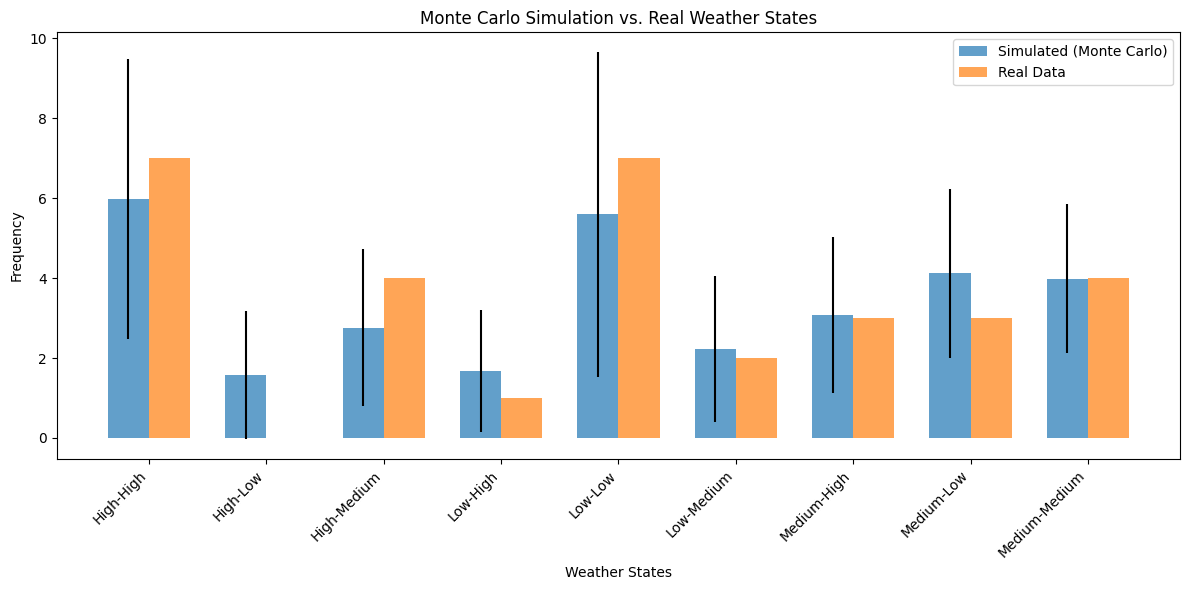

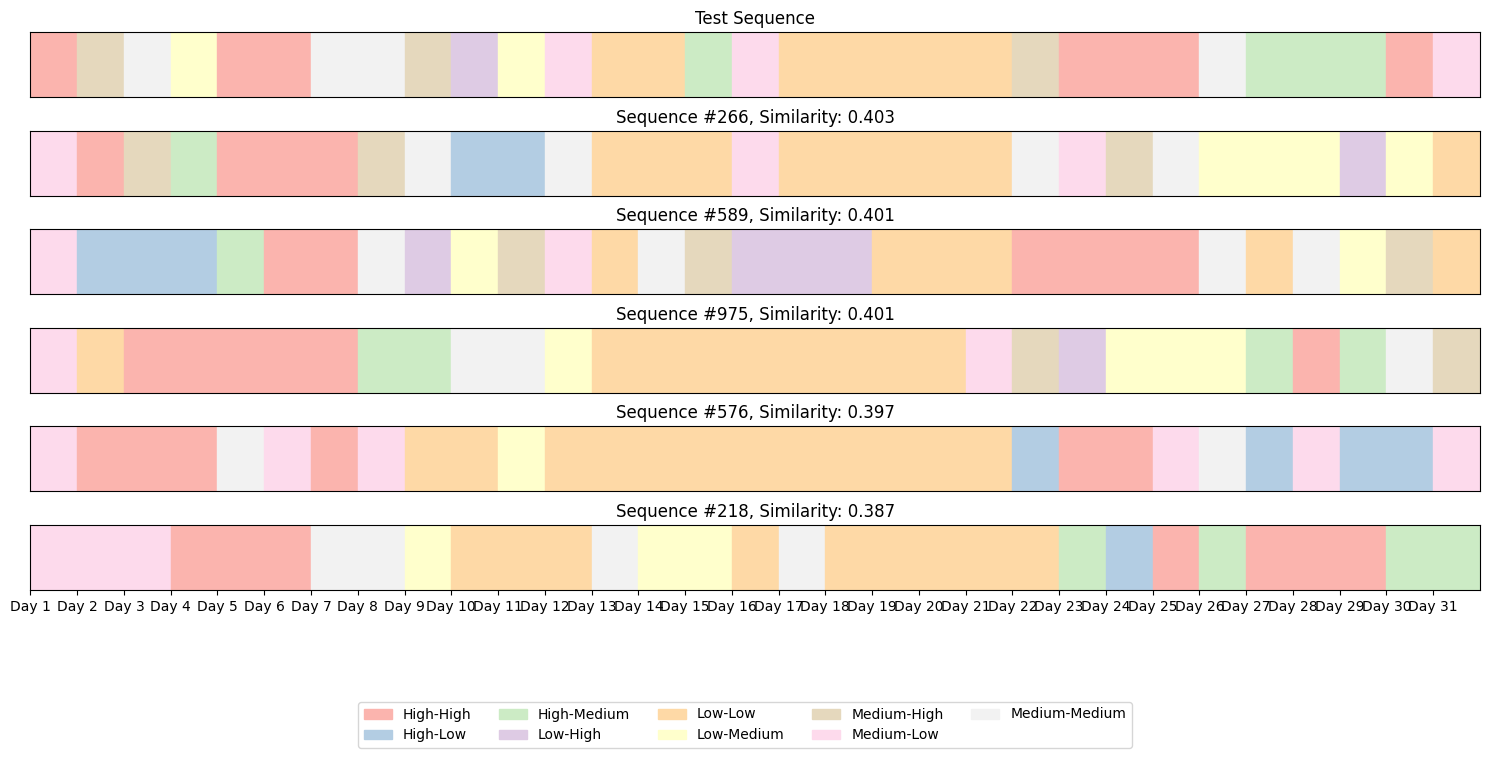

In [64]:
# Run Monte Carlo simulation
mc_results = monte_carlo_markov_chain(
    transition_matrix=transition_matrix,
    states=all_states, 
    steps=30,  # for January
    n_simulations=1000, 
)

# Analyze results
analysis = analyze_monte_carlo_results(
    mc_results=mc_results,
    real_data=state_counts_test, 
    states=all_states,
    test_sequence= state_sequence_test
)